# Setup & Imports

In [11]:
# # Customer Churn Prediction

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

# **Data Loading**

In [13]:
# ## Section 2: Data Loading

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("BankChurners2copy.csv")
print("Data shape:", df.shape)
df.head()

Saving BankChurners2copy.csv to BankChurners2copy (2).csv
Data shape: (10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


## Initial Data Inspection

In [14]:
# ## Section 3: Initial Data Inspection

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Unique Values ===")
print(df.nunique())



=== Data Types ===
CLIENTNUM                                                                                                                               int64
Attrition_Flag                                                                                                                         object
Customer_Age                                                                                                                            int64
Gender                                                                                                                                 object
Dependent_count                                                                                                                         int64
Education_Level                                                                                                                        object
Marital_Status                                                                                                                  

In [16]:
# Drop problematic columns
df_clean = df.drop(columns=[
    'CLIENTNUM',  # ID column
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
], axis=1)

# Convert target to binary
df_clean['Attrition_Flag'] = df_clean['Attrition_Flag'].map({
    'Existing Customer': 0,
    'Attrited Customer': 1
})

# Verify preprocessing
print("Remaining columns:")
print(df_clean.columns.tolist())
print("\nTarget distribution:")
print(df_clean['Attrition_Flag'].value_counts(normalize=True))

Remaining columns:
['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

Target distribution:
Attrition_Flag
0    0.83934
1    0.16066
Name: proportion, dtype: float64


# **Exploratory Data Analysis (EDA)**

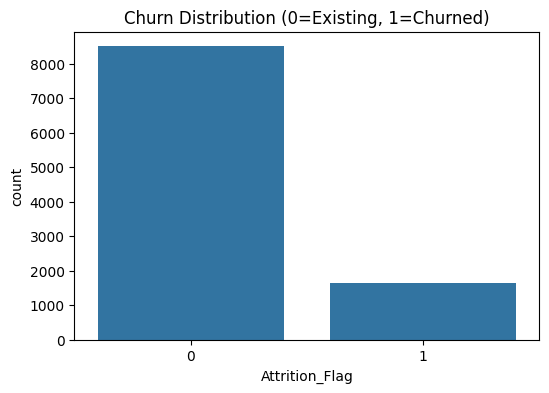

In [17]:
# ## Section 5: Exploratory Data Analysis (EDA)

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition_Flag', data=df_clean)
plt.title('Churn Distribution (0=Existing, 1=Churned)')
plt.show()

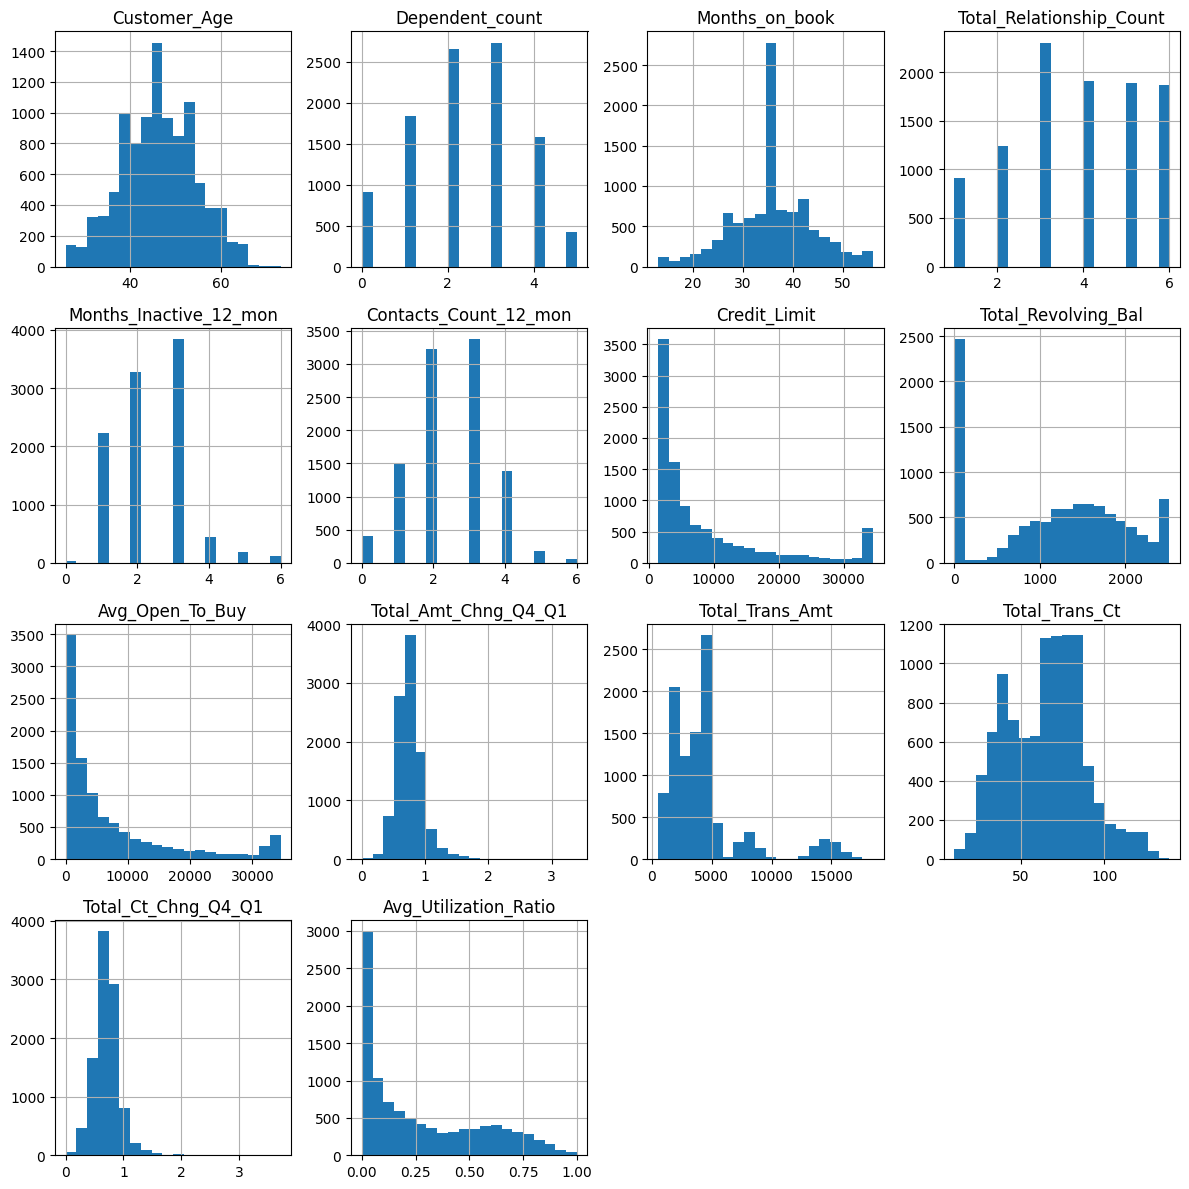

In [32]:
# Numerical features distribution
num_cols = df_clean.select_dtypes(include=np.number).columns.drop('Attrition_Flag')
df_clean[num_cols].hist(figsize=(12,12), bins=20)
plt.tight_layout()
plt.show()

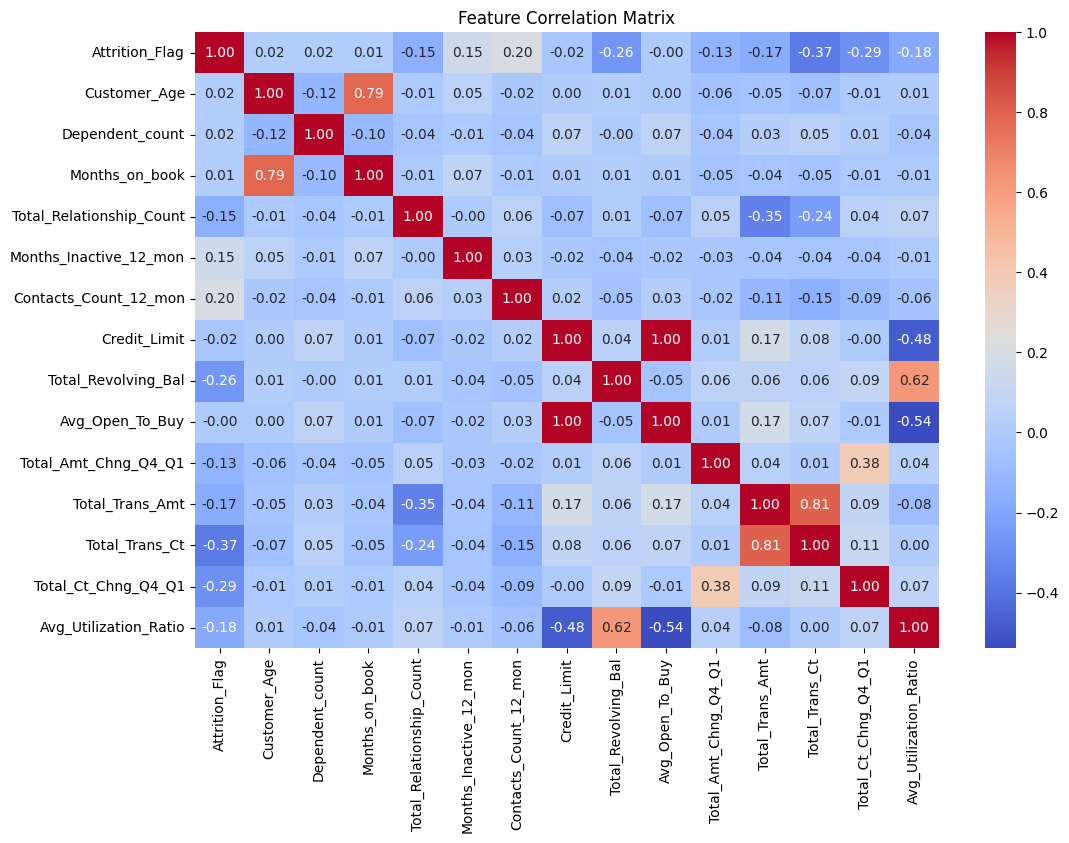

In [20]:
# Correlation matrix
plt.figure(figsize=(12,8))
corr = df_clean.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# **Feature Engineering**

In [21]:

# Separate features and target
y = df_clean['Attrition_Flag']
X = df_clean.drop('Attrition_Flag', axis=1)

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (8101, 32)
Test set shape: (2026, 32)


# **Model Training**

In [22]:
# Initialize and train model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

# Dummy classifier for baseline
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train_scaled, y_train)

print("Model training complete!")


Model training complete!


# **Model Evaluation**


=== Model Performance ===
Accuracy: 0.9353

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1701
           1       0.77      0.85      0.81       325

    accuracy                           0.94      2026
   macro avg       0.87      0.90      0.88      2026
weighted avg       0.94      0.94      0.94      2026


Confusion Matrix:


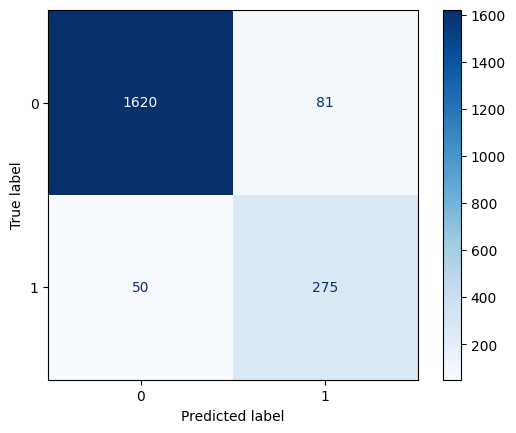


=== Baseline Performance ===
Dummy Classifier Accuracy: 0.7226


In [24]:
# ## Section 8: Model Evaluation

# Make predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

# Evaluation metrics
print("\n=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

# Baseline comparison
print("\n=== Baseline Performance ===")
print(f"Dummy Classifier Accuracy: {dummy.score(X_test_scaled, y_test):.4f}")


# **Feature Importance**

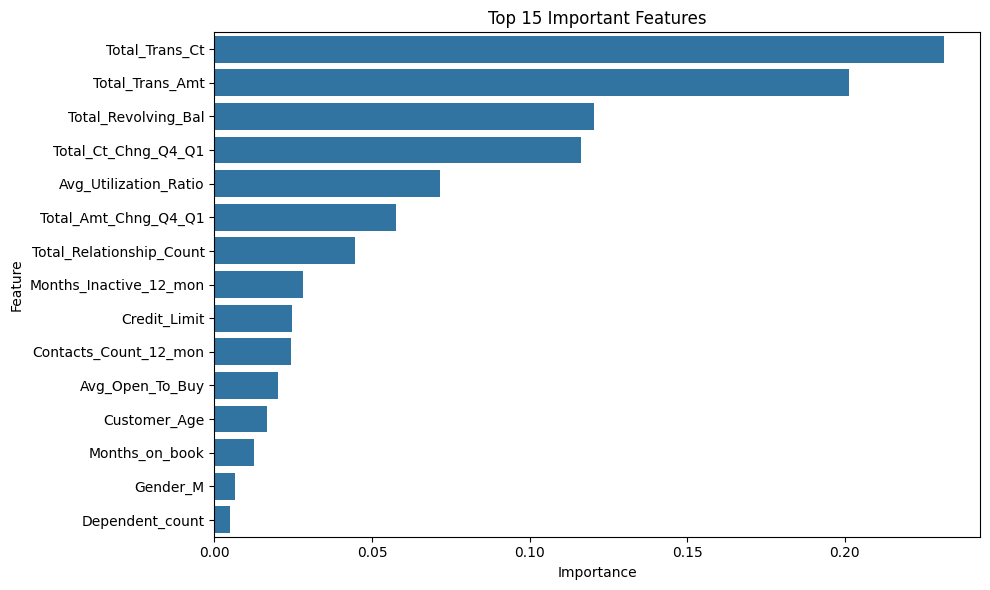

In [25]:
# ## Section 9: Feature Importance

# Get feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()


In [26]:
# Create prediction dataframe
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_proba
})

# Add original features for context
results = pd.concat([
    results.reset_index(drop=True),
    X_test.reset_index(drop=True)
], axis=1)

# Display sample predictions
print("Sample Predictions:")
display(results.sample(10))

Sample Predictions:


,Actual,Predicted,Probability,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
2015,0,0,0.207417,53,0,33,4,3,3,21006.0,...,False,False,False,False,False,False,False,False,False,False
1513,0,0,0.052026,42,2,32,5,2,2,22120.0,...,False,False,False,False,True,False,False,False,False,False
667,0,0,0.078665,44,3,36,4,3,1,22919.0,...,False,False,False,True,False,False,False,False,False,False
1294,0,0,0.278346,31,1,26,4,1,2,2037.0,...,True,False,True,False,False,False,False,False,False,False
845,0,0,0.012493,43,4,30,3,2,1,2397.0,...,False,True,False,False,False,True,False,False,False,False
1852,0,0,0.024963,59,1,52,6,3,3,2308.0,...,False,False,False,False,False,True,False,False,False,False
859,0,0,0.066073,34,2,17,3,1,2,5030.0,...,True,False,False,False,False,False,False,False,False,False
513,0,0,0.129549,51,3,46,1,3,1,11765.0,...,False,False,False,False,True,False,False,False,False,False
1167,1,1,0.619168,51,1,36,2,3,2,2710.0,...,False,False,True,False,False,False,False,False,False,False
958,0,0,0.019643,49,1,43,3,3,2,3054.0,...,False,False,True,False,False,False,False,False,False,False


# **Debugging Checks**


=== Debugging Checks ===

1. Checking for target in features:
[]

2. Feature variances:
Marital_Status_Unknown            1.000123
Income_Category_$40K - $60K       1.000123
Education_Level_Uneducated        1.000123
Card_Category_Silver              1.000123
Education_Level_High School       1.000123
Card_Category_Platinum            1.000123
Education_Level_Post-Graduate     1.000123
Card_Category_Gold                1.000123
Contacts_Count_12_mon             1.000123
Education_Level_Doctorate         1.000123
Marital_Status_Single             1.000123
Income_Category_$80K - $120K      1.000123
Income_Category_Less than $40K    1.000123
Months_on_book                    1.000123
Dependent_count                   1.000123
Total_Relationship_Count          1.000123
Total_Revolving_Bal               1.000123
Avg_Utilization_Ratio             1.000123
Avg_Open_To_Buy                   1.000123
Credit_Limit                      1.000123
Total_Trans_Amt                   1.000123
Total_Am

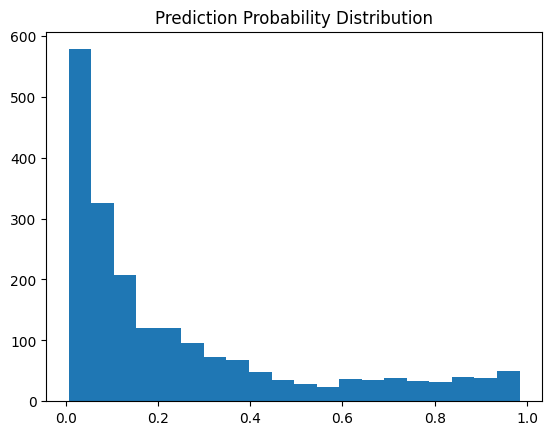

In [27]:
print("\n=== Debugging Checks ===")

# Check for data leakage
print("\n1. Checking for target in features:")
print([col for col in X.columns if 'attrit' in col.lower()])

# Check feature variances
print("\n2. Feature variances:")
print(pd.DataFrame(X_train_scaled, columns=X.columns).var().sort_values())

# Check correlations
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print("\n3. Highly correlated features (>0.95):")
print([column for column in upper.columns if any(upper[column] > 0.95)])

# Check model calibration
print("\n4. Prediction probability distribution:")
plt.hist(y_proba, bins=20)
plt.title('Prediction Probability Distribution')
plt.show()